In [1]:
import sys
import os

# Projektverzeichnis
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Füge dem sys.path hinzu, falls noch nicht vorhanden
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# Datenzugriff
from configs.path_manager import get_path
from models import *

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term
from src.utils.production_process import gen_deadline as gen_deadline
from src.utils.production_process import filter as process_filter

# Solver Model
from src.models.cp import lateness_scheduling as cp_late_schedule
from src.models.cp import lateness_rescheduling as cp_late_reschedule
import src.models.heuristics.fcfs as fcfs


# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Extern
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 21)

In [3]:
max_time = 60 * 15 # 15 min

In [4]:
Job.clone_jobs(referenced_version="base", new_version="lateness_plus")
JSSP_LIVE.clone_operations(referenced_version="base", new_version="lateness_plus")

✅ 7250 Jobs von Version 'base' nach Version 'lateness_plus' kopiert.
✅ 0 JSSP_LIVE-Einträge von Version 'base' nach Version 'lateness_plus' kopiert.


## Laden des fertigen Datensatzes (3 Tage Ankunft)

In [5]:
# Jobs
df_jobs_times = Job.get_dataframe(version="lateness_plus")
df_jobs_times = df_jobs_times[df_jobs_times.Arrival <= 60*24*3]
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0000,8,79,1440,3660,open,lateness_plus
1,J25-0001,6,129,1440,2338,open,lateness_plus
2,J25-0002,0,198,1440,3744,open,lateness_plus
3,J25-0003,2,243,1440,3379,open,lateness_plus
4,J25-0004,3,287,1440,4856,open,lateness_plus
...,...,...,...,...,...,...,...
59,J25-0059,1,4076,4320,6187,open,lateness_plus
60,J25-0060,1,4147,4320,5633,open,lateness_plus
61,J25-0061,9,4233,4320,6533,open,lateness_plus
62,J25-0062,6,4259,4320,6091,open,lateness_plus


In [6]:
# Routings
df_routings = RoutingOperation.get_dataframe()
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
...,...,...,...,...
95,9,5,M09,76
96,9,6,M05,47
97,9,7,M03,52
98,9,8,M04,90


In [7]:
def get_jssp_for_jobs(df_jobs_times, df_routings):
    """
    Erstellt ein JSSP-kompatibles DataFrame durch Verknüpfung von Job-Zeitdaten mit Routings.

    Parameter:
    - df_jobs_times: DataFrame mit mindestens den Spalten 'Job' und 'Routing_ID'.
    - df_routings: DataFrame mit Spalte 'Routing_ID' und den zugehörigen Operationsdaten.

    Rückgabe:
    - df_jssp: DataFrame mit allen für das JSSP notwendigen Informationen, inklusive 'Job' und den Operationen.
    """
    # 1. Relevante Spalten extrahieren
    df_job_ids = df_jobs_times[['Job', 'Routing_ID']].copy()

    # 2. Merge mit df_routings über Routing_ID
    df_jssp = df_job_ids.merge(df_routings, on='Routing_ID')

    return df_jssp

In [8]:
df_jssp = get_jssp_for_jobs(df_jobs_times, df_routings)
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
...,...,...,...,...,...
635,J25-0063,3,5,M08,52
636,J25-0063,3,6,M07,85
637,J25-0063,3,7,M03,98
638,J25-0063,3,8,M09,22


In [9]:
JSSP_LIVE.add_from_dataframe(df_jssp, version="lateness_plus", status="open")

✅ 640 JSSP_LIVE-Einträge (Version 'lateness_plus', Status 'open') wurden hinzugefügt oder aktualisiert.


### Params

In [10]:
day_length = 1440
day_numb = 0
day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 00: [0, 1440)


## Tag 1 (init. Tag - kein Rescheduling)

In [11]:
day_numb = 1

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [12]:
# alle aktuelle "offenen" Jobs
df_job_times_curr = Job.get_dataframe(version="lateness_plus", arrival_time_max=day_start, status="open")
df_job_times_curr

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0000,8,79,1440,3660,open,lateness_plus
1,J25-0001,6,129,1440,2338,open,lateness_plus
2,J25-0002,0,198,1440,3744,open,lateness_plus
3,J25-0003,2,243,1440,3379,open,lateness_plus
4,J25-0004,3,287,1440,4856,open,lateness_plus
5,J25-0005,1,498,1440,3106,open,lateness_plus
6,J25-0006,9,790,1440,3539,open,lateness_plus
7,J25-0007,5,925,1440,2929,open,lateness_plus
8,J25-0008,4,988,1440,3541,open,lateness_plus
9,J25-0009,7,1004,1440,3578,open,lateness_plus


In [13]:
#  JSSP zu allen "offenen" Jobs
df_jssp_temp = get_jssp_for_jobs(df_job_times_curr, df_routings)
df_jssp_temp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
...,...,...,...,...,...
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47
157,J25-0015,5,7,M06,65
158,J25-0015,5,8,M04,6


In [14]:
#  JSSP zu allen "offenen" Jobs, mit "offenen" Operationen
df_jobs_ops = JSSP_LIVE.get_dataframe(version="lateness_plus", jobs=df_jssp_temp.Job.tolist(), status="open")
df_jssp_curr = df_jssp_temp.merge(df_jobs_ops[['Job', 'Operation']], on=['Job', 'Operation'], how='inner')
df_jssp_curr

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
...,...,...,...,...,...
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47
157,J25-0015,5,7,M06,65
158,J25-0015,5,8,M04,6


### A) Scheduling

In [15]:
# Scheduling
df_schedule = cp_late_schedule.solve_jssp_sum_by_tardiness_and_earliness(df_jssp_curr, df_job_times_curr, 
                                                                         schedule_start = day_start, w_t=5,
                                                                         msg=False, timeLimit=max_time)
df_schedule 


Solver-Status         : OPTIMAL
Objective Value       : 0.00
Best Objective Bound  : 0.00
Laufzeit              : 0.09 Sekunden


,Job,Routing_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,J25-0005,1,0,M00,498,3106,1440,43,1483,-1623,0,1623
1,J25-0007,5,0,M02,925,2929,1440,84,1524,-1405,0,1405
2,J25-0013,3,0,M01,1192,2567,1440,81,1521,-1046,0,1046
3,J25-0011,1,0,M00,1030,3210,1483,43,1526,-1684,0,1684
4,J25-0001,6,0,M01,129,2338,1521,46,1567,-771,0,771
...,...,...,...,...,...,...,...,...,...,...,...,...
155,J25-0009,7,9,M03,1004,3578,3499,79,3578,0,0,0
156,J25-0000,8,9,M08,79,3660,3586,74,3660,0,0,0
157,J25-0002,0,9,M09,198,3744,3723,21,3744,0,0,0
158,J25-0012,2,9,M04,1103,4385,4352,33,4385,0,0,0


In [16]:
json_schedule = df_schedule.to_dict(orient='records')

Schedule.add_schedule(
    data=json_schedule,
    date=day_numb,
    version="lateness_plus"
)

✅ Schedule hinzugefügt (Version=lateness_plus, Date=1)


### B) Simulation

In [17]:
simulation = ProductionSimulation(df_schedule, sigma=0.2)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0005 started on M00
[Day 1 00:00:00] Job J25-0007 started on M02
[Day 1 00:00:00] Job J25-0013 started on M01
[Day 1 00:40:20] Job J25-0005 finished on M00 (after 40 minutes 21 seconds)
[Day 1 00:43:00] Job J25-0011 started on M00
[Day 1 01:08:52] Job J25-0013 finished on M01 (after 68 minutes 52 seconds)
[Day 1 01:20:57] Job J25-0007 finished on M02 (after 80 minutes 58 seconds)
[Day 1 01:21:00] Job J25-0001 started on M01
[Day 1 01:24:00] Job J25-0013 started on M02
[Day 1 01:31:37] Job J25-0011 finished on M00 (after 48 minutes 37 seconds)
[Day 1 01:31:37] Job J25-0010 started on M00
[Day 1 01:59:39] Job J25-0010 finished on M00 (after 28 minutes 02 seconds)
[Day 1 01:59:39] Job J25-0000 started on M00
[Day 1 02:03:37] Job J25-0001 finished on M01 (after 42 minutes 38 seconds)
[Day 1 02:07:00] Job J25-0007 started on M01
[Day 1 02:09:10] Job J25-0007 finished on M01 (after 02 minutes 10 seconds)
[Day 1 02:09:10] Job J25-0003 started on M01
[Day 1 02:09:10] J

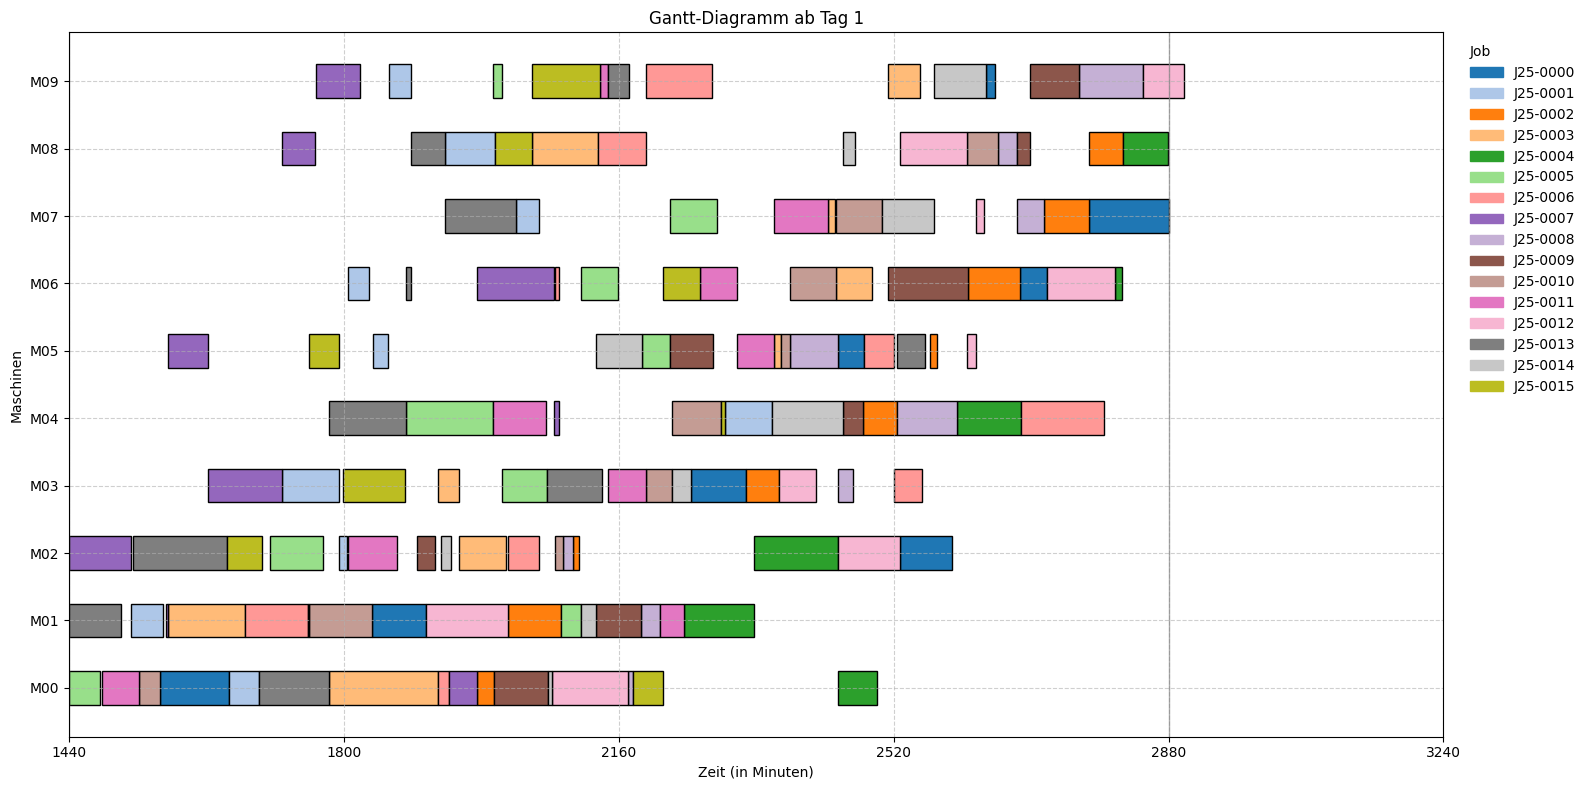

In [18]:
show.plot_gantt(df_execution, perspective="Machine", title=f"Gantt-Diagramm ab Tag {day_numb}")

In [19]:
df_ops_finished = df_execution[df_execution.End < day_end]
JSSP_LIVE.add_from_dataframe(df_ops_finished, version="lateness_plus", status="finished")
df_ops_finished

✅ 139 JSSP_LIVE-Einträge (Version 'lateness_plus', Status 'finished') wurden hinzugefügt oder aktualisiert.


,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End
0,J25-0000,8,0,M00,79,1559.66,90.41,1650.07
1,J25-0000,8,1,M01,79,1836.35,70.71,1907.06
2,J25-0000,8,2,M03,79,2255.02,72.09,2327.11
3,J25-0000,8,3,M05,79,2447.22,34.05,2481.27
4,J25-0000,8,4,M02,79,2528.85,67.04,2595.89
...,...,...,...,...,...,...,...,...
136,J25-0015,5,4,M08,1436,1998.18,47.91,2046.09
137,J25-0015,5,5,M09,1436,2046.09,89.11,2135.20
138,J25-0015,5,6,M00,1436,2178.44,39.63,2218.07
139,J25-0015,5,7,M06,1436,2218.07,48.17,2266.24


In [20]:
JSSP_LIVE.update_closed_jobs_from_operations(version="lateness_plus")

✅ 2 Job(s) wurden auf 'closed' gesetzt (Version 'lateness_plus').


['J25-0001', 'J25-0013']

In [21]:
df_ops_in_progess = df_execution[df_execution.End >= day_end]
JSSP_LIVE.add_from_dataframe(df_ops_in_progess, version="lateness_plus", status="in progress")
df_ops_in_progess

✅ 2 JSSP_LIVE-Einträge (Version 'lateness_plus', Status 'in progress') wurden hinzugefügt oder aktualisiert.


,Job,Routing_ID,Operation,Machine,Arrival,Start,Processing Time,End
7,J25-0000,8,7,M07,79,2776.18,104.26,2880.44
112,J25-0012,2,8,M09,1103,2846.11,53.91,2900.02


## II) Tag 2

In [22]:
this_version = "lateness_plus"

In [23]:
day_numb = 2

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [24]:
# alle aktuelle "offenen" Jobs
df_jobs_times_curr = Job.get_dataframe(version=this_version, arrival_time_max=day_start, status="open")
df_jobs_times_curr

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0000,8,79,1440,3660,open,lateness_plus
1,J25-0002,0,198,1440,3744,open,lateness_plus
2,J25-0003,2,243,1440,3379,open,lateness_plus
3,J25-0004,3,287,1440,4856,open,lateness_plus
4,J25-0005,1,498,1440,3106,open,lateness_plus
...,...,...,...,...,...,...,...
31,J25-0033,2,2660,2880,6738,open,lateness_plus
32,J25-0034,8,2715,2880,6387,open,lateness_plus
33,J25-0035,5,2726,2880,4126,open,lateness_plus
34,J25-0036,4,2734,2880,5231,open,lateness_plus


In [25]:
#  JSSP zu allen "offenen" Jobs (auch fertige Operationen)
df_jssp_temp = get_jssp_for_jobs(df_jobs_times_curr, df_routings)


#  JSSP zu allen "offenen" Jobs, mit "offenen" Operationen
df_jobs_ops = JSSP_LIVE.get_dataframe(version=this_version, jobs=df_jssp_temp.Job.tolist(), status="open")
df_jssp_curr = df_jssp_temp.merge(df_jobs_ops[['Job', 'Operation']], on=['Job', 'Operation'], how='inner')
df_jssp_curr

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,8,M04,26
1,J25-0000,8,9,M08,74
2,J25-0002,0,9,M09,21
3,J25-0003,2,9,M04,33
4,J25-0004,3,6,M07,85
...,...,...,...,...,...
234,J25-0037,7,5,M06,88
235,J25-0037,7,6,M08,19
236,J25-0037,7,7,M09,48
237,J25-0037,7,8,M07,36


In [26]:
# Relevante 
df_ops_in_progess = JSSP_LIVE.get_dataframe(version=this_version, status="in progress")
df_ops_in_progess

,Job,Routing_ID,Machine,Operation,Start,End,Processing Time,Version,Operation Status
0,J25-0000,8,M07,7,2776.18,2880.44,104.26,lateness_plus,in progress
1,J25-0012,2,M09,8,2846.11,2900.02,53.91,lateness_plus,in progress


In [27]:
## Hole den vorherigen Schedule
df_schedule = Schedule.get_schedule_as_dataframe(date=day_numb-1, version=this_version)

# Hole die offenen Operationen für die enthaltenen Jobs
df_open_ops = JSSP_LIVE.get_dataframe(version=this_version, jobs=df_schedule["Job"].unique().tolist(), status="open")

# Mache ein Inner Join auf ["Job", "Operation"]
df_schedule_prev = df_schedule.merge(df_open_ops[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
df_schedule_prev

ℹ️ Achtung: 12 Schedules gefunden – letzter Eintrag (ID 26) wird verwendet.


,Job,Routing_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,J25-0000,8,8,M04,79,3660,2808,26,2834,-826,0,826
1,J25-0009,7,8,M07,1004,3578,2808,36,2844,-734,0,734
2,J25-0007,5,9,M07,925,2929,2904,25,2929,0,0,0
3,J25-0015,5,9,M07,1436,2981,2956,25,2981,0,0,0
4,J25-0004,3,6,M07,287,4856,2981,85,3066,-1790,0,1790
5,J25-0004,3,7,M03,287,4856,3066,98,3164,-1692,0,1692
6,J25-0005,1,9,M08,498,3106,3076,30,3106,0,0,0
7,J25-0004,3,8,M09,287,4856,3164,22,3186,-1670,0,1670
8,J25-0011,1,9,M08,1030,3210,3180,30,3210,0,0,0
9,J25-0014,4,9,M06,1222,3315,3262,53,3315,0,0,0


### Rescheduling

#### Old Version

$$
min   Z = r \cdot \sum_{j \in \text{Jobs}} \left( w_t \cdot \text{Tardiness}_j + w_e \cdot \text{Earliness}_j \right) + (1 - r) \cdot \sum_{(j,o) \in \text{DevOps}} \left| \text{Start}_{j,o} - \text{Start}_{j,o}^{\text{original}} \right|
$$



Solver-Status         : OPTIMAL
Objective Value       : 15280.00
Best Objective Bound  : 15280.00
Laufzeit              : 1.44 Sekunden
Deviation terms       : 19


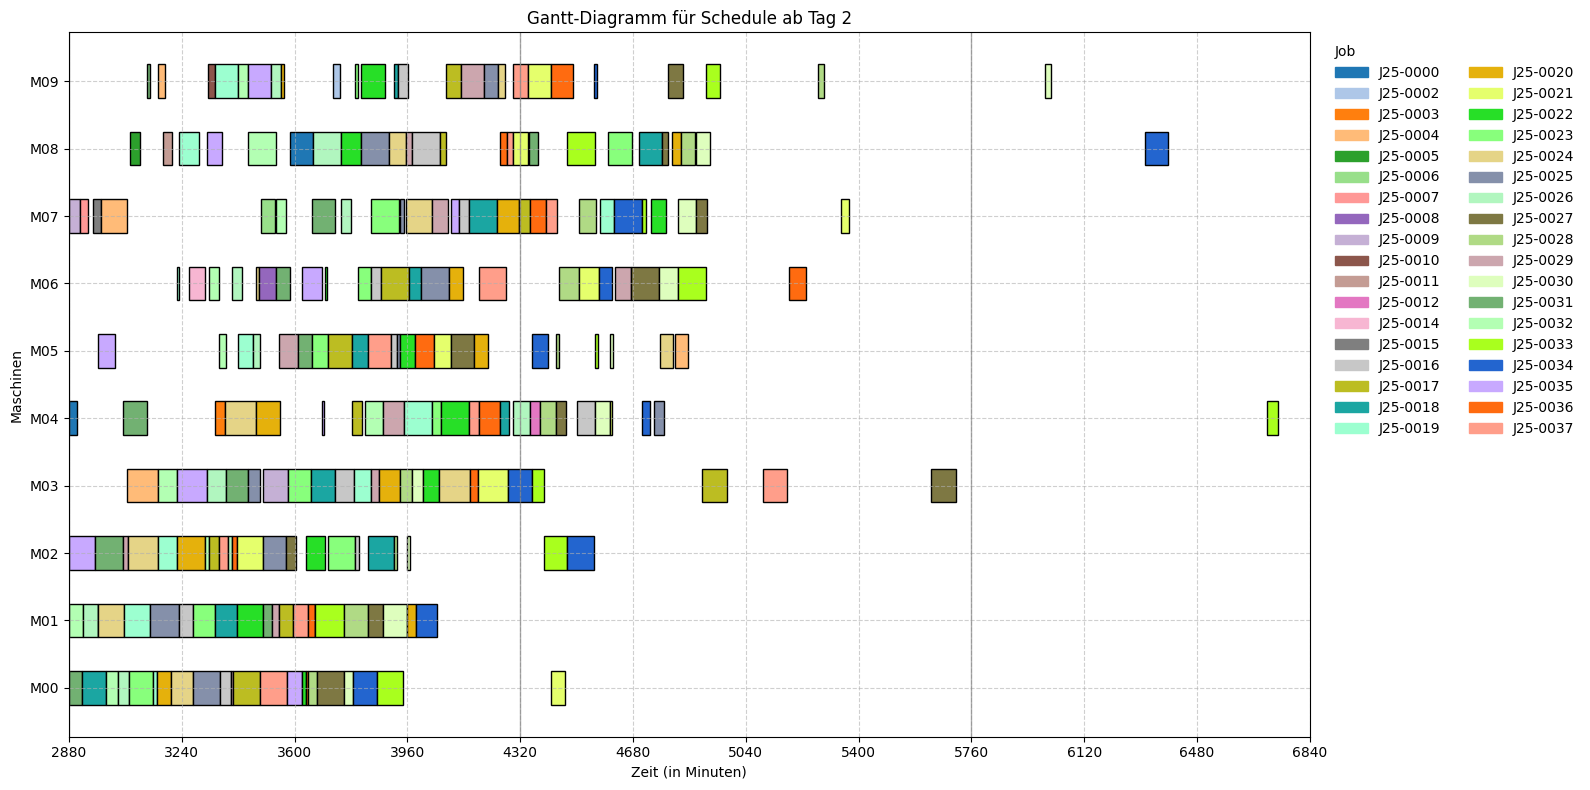

In [28]:
df_schedule = cp_late_reschedule.solve_jssp_by_tardiness_and_earliness_with_devpen(df_jssp_curr, df_jobs_times_curr, 
                                                                                   df_ops_in_progess, 
                                                                                   df_original_plan = df_schedule_prev,
                                                                                   w_t = 5,
                                                                                   r = 0.2, # 20% Lateness, 80% Deviation
                                                                                   reschedule_start = day_start, 
                                                                                   msg=False, timeLimit=max_time, gapRel= 0.001)

show.plot_gantt(df_schedule, perspective="Machine", title=f"Gantt-Diagramm für Schedule ab Tag {day_numb}")

$$
Z = \alpha \cdot \left[
r \cdot \sum_{j \in \text{Jobs}} \left( w_t \cdot \max(0, C_j - D_j) + w_e \cdot \max(0, D_j - C_j) \right)
+ (1 - r) \cdot \sum_{(j,o) \in \text{DevOps}} \left| S_{j,o} - S_{j,o}^{\text{orig}} \right|
\right]
- (1 - \alpha) \cdot \sum_{j \in \text{Jobs}} S_j^{\text{first}}
$$



Solver-Status         : OPTIMAL
Objective Value       : 0.00
Best Objective Bound  : 0.00
Laufzeit              : 4.21 Sekunden
Deviation terms       : 19


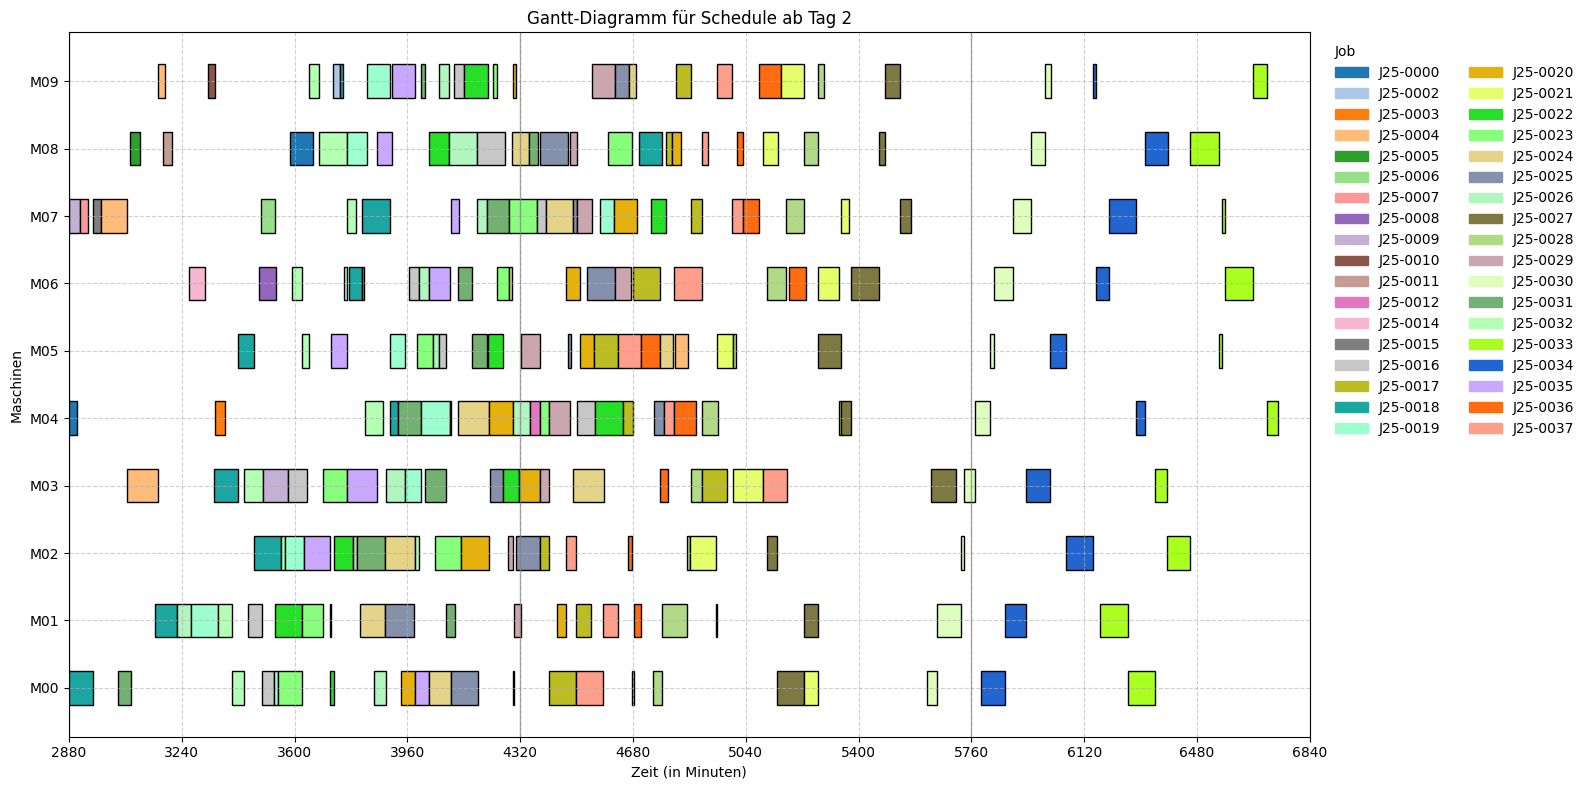

In [29]:
df_schedule = cp_late_reschedule.solve_jssp_advanced(df_jssp_curr, df_jobs_times_curr, df_ops_in_progess, 
                                                      df_original_plan = df_schedule_prev, w_t = 5,
                                                       r = 0.2, # 20% Lateness, 80% Deviation
                                                       reschedule_start = day_start, 
                                                       msg=False, timeLimit=max_time, gapRel= 0.001,
                                                      alpha =0.90)

show.plot_gantt(df_schedule, perspective="Machine", title=f"Gantt-Diagramm für Schedule ab Tag {day_numb}")

# Simulation 

In [30]:
simulation = ProductionSimulation(df_schedule, sigma=0.2)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[Day 2 00:00:00] Job J25-0018 started on M00
[Day 2 00:01:00] Job J25-0000 started on M04
[Day 2 00:01:00] Job J25-0009 started on M07
[Day 2 00:31:54] Job J25-0000 finished on M04 (after 30 minutes 55 seconds)
[Day 2 00:33:39] Job J25-0009 finished on M07 (after 32 minutes 39 seconds)
[Day 2 00:37:00] Job J25-0007 started on M07
[Day 2 01:03:46] Job J25-0007 finished on M07 (after 26 minutes 46 seconds)
[Day 2 01:03:59] Job J25-0018 finished on M00 (after 63 minutes 59 seconds)
[Day 2 01:16:00] Job J25-0015 started on M07
[Day 2 01:34:22] Job J25-0015 finished on M07 (after 18 minutes 22 seconds)
[Day 2 01:41:00] Job J25-0004 started on M07
[Day 2 02:36:00] Job J25-0031 started on M00
[Day 2 03:05:48] Job J25-0004 finished on M07 (after 84 minutes 49 seconds)
[Day 2 03:06:00] Job J25-0004 started on M03
[Day 2 03:09:11] Job J25-0031 finished on M00 (after 33 minutes 11 seconds)
[Day 2 03:16:00] Job J25-0005 started on M08
[Day 2 03:39:44] Job J25-0005 finished on M08 (after 23 minutes